C:\Users\G Mahathi\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\G Mahathi\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.4346, Val Loss: 0.2494
Epoch 2/5, Train Loss: 0.2795, Val Loss: 0.3679
Epoch 3/5, Train Loss: 0.2080, Val Loss: 0.5537
Epoch 4/5, Train Loss: 0.1987, Val Loss: 0.3296
Epoch 5/5, Train Loss: 0.1468, Val Loss: 0.2182


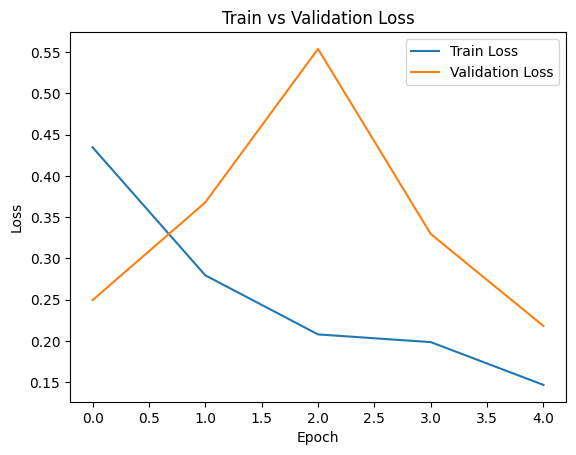


✅ Test Accuracy: 0.9730

📊 Classification Report:
               precision    recall  f1-score   support

   Defective       0.95      1.00      0.97        55
      Normal       1.00      0.95      0.97        56

    accuracy                           0.97       111
   macro avg       0.97      0.97      0.97       111
weighted avg       0.97      0.97      0.97       111



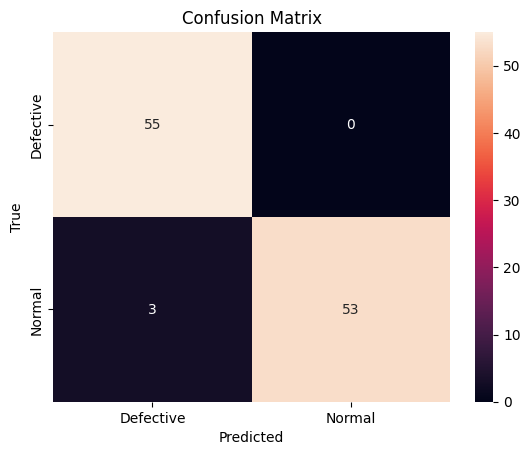


Showing Correctly Classified predictions:



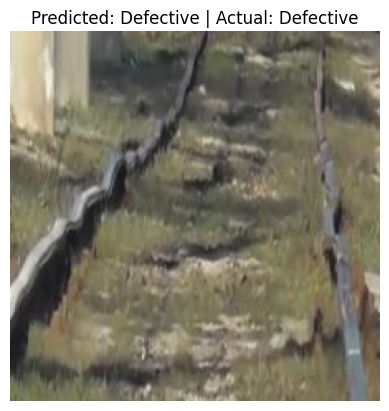

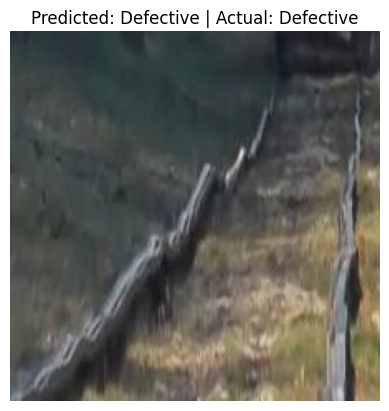

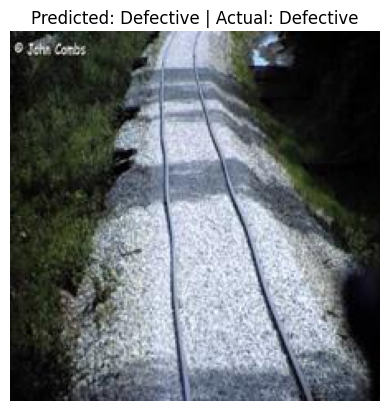

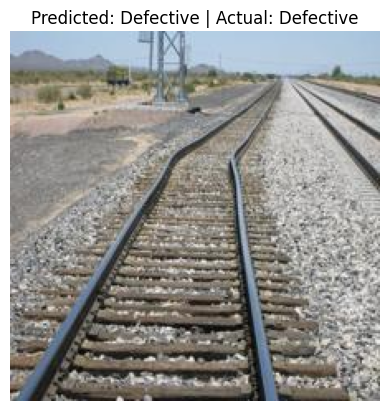

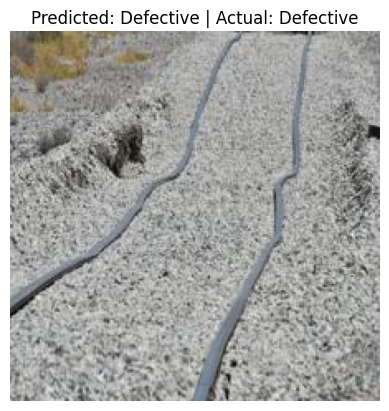

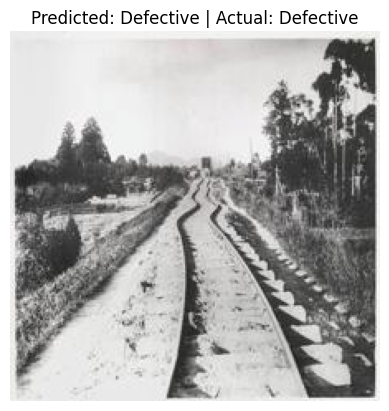


Showing Incorrectly Classified predictions:



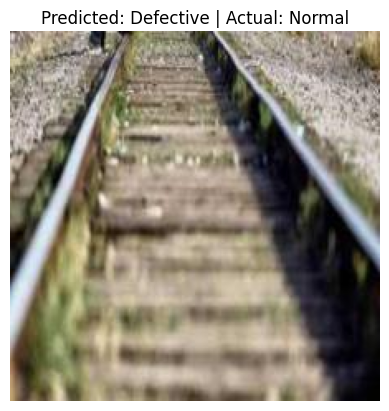

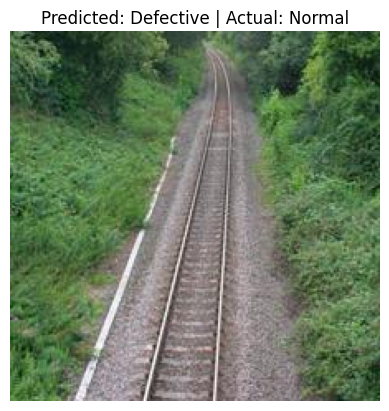

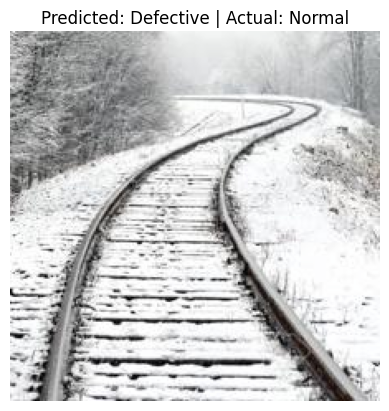

In [8]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import models

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import os


device = torch.device("cpu")

train_path = 'NewR22/train'
test_path = 'NewR22/test'

# Transforms
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Datasets
full_train_dataset = ImageFolder(train_path, transform=transform_train)
test_dataset = ImageFolder(test_path, transform=transform_test)

#  Split into train and validation
val_size = int(0.2 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

#  Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load ResNet50
def get_resnet50():
    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 2)
    return model.to(device)

# Training with validation and loss tracking
def train_model(model, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Plot Loss Curves
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Validation Loss")
    plt.legend()
    plt.show()

    return model

# Evaluate
def evaluate_model(model):
    model.eval()
    y_true, y_pred = [], []
    correct_images = []
    incorrect_images = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true += labels.cpu().tolist()
            y_pred += preds.cpu().tolist()

            for i in range(inputs.size(0)):
                img = inputs[i].cpu().permute(1, 2, 0).numpy()
                img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)
                if preds[i] == labels[i]:
                    correct_images.append((img, preds[i], labels[i]))
                else:
                    incorrect_images.append((img, preds[i], labels[i]))

    acc = accuracy_score(y_true, y_pred)
    print(f"\n Test Accuracy: {acc:.4f}")
    print("\n Classification Report:\n", classification_report(y_true, y_pred, target_names=full_train_dataset.classes))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=full_train_dataset.classes, yticklabels=full_train_dataset.classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return correct_images, incorrect_images

def show_predictions(images, title, max_images=6):
    print(f"\nShowing {title} predictions:\n")
    for i, (img, pred, label) in enumerate(images[:max_images]):
        plt.imshow(img)
        plt.title(f"Predicted: {full_train_dataset.classes[pred]} | Actual: {full_train_dataset.classes[label]}")
        plt.axis("off")
        plt.show()

model = get_resnet50()
model = train_model(model, epochs=5)
correct_imgs, incorrect_imgs = evaluate_model(model)
show_predictions(correct_imgs, "Correctly Classified")
show_predictions(incorrect_imgs, "Incorrectly Classified")
